In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# **Import data from google drive**

d_{networkname}_s = the spatial data of average distance accross layers computed by the network

target = labels for each tiral, (1:right image is prefered, 0:left image is prefered)

In [3]:
d_vgg_s=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/d_vgg_s.npy',allow_pickle=True)
target=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/target_data_Eddy_random.npy')

In [4]:
left_img=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/left_img_data_random.npy')
right_img=np.load(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Data/right_img_data_random.npy')

Extracting and modify the data we are going to use in this experiment.

In [5]:
d_vgg_s_clean=[]
for d in d_vgg_s:
  d_vgg_s_clean.append(d[0].data.cpu().numpy().reshape(512,512))
del d_vgg_s

In [6]:
d_vgg_s_clean=np.array(d_vgg_s_clean)
target=np.array(target)

Training example plotting.

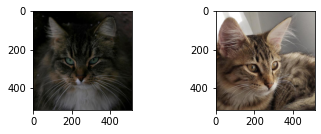

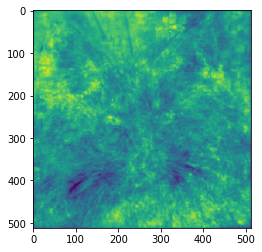

In [7]:
img_index=0 # the first pair of image trial
plt.subplot(2,2,1)
plt.imshow(left_img[img_index])
plt.subplot(2,2,2)
plt.imshow(right_img[img_index])
plt.show()
plt.imshow(d_vgg_s_clean[img_index])

In [8]:
d_vgg_s_clean[img_index]

array([[0.5929284 , 0.604228  , 0.6175002 , ..., 0.48528776, 0.46267387,
        0.45744988],
       [0.6115252 , 0.6052678 , 0.65111923, ..., 0.497171  , 0.46079466,
        0.45779058],
       [0.65361863, 0.61188567, 0.6512842 , ..., 0.5284326 , 0.4623675 ,
        0.46499887],
       ...,
       [0.40261358, 0.423729  , 0.48415282, ..., 0.40622613, 0.30827624,
        0.28459162],
       [0.38759184, 0.41812748, 0.42866042, ..., 0.29404286, 0.2672551 ,
        0.25059915],
       [0.3896898 , 0.41431576, 0.44226652, ..., 0.2835531 , 0.25043076,
        0.23807758]], dtype=float32)

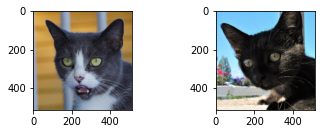

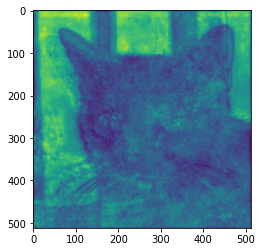

In [9]:
img_index=1 # the first pair of image trial
plt.subplot(2,2,1)
plt.imshow(left_img[img_index])
plt.subplot(2,2,2)
plt.imshow(right_img[img_index])
plt.show()
plt.imshow(d_vgg_s_clean[img_index])

In [10]:
del left_img
del right_img

Here we check the quantities of each classes.

We can see Eddy's behavior data is slightly class imbalance.

In [11]:
print(np.count_nonzero(target ==1))
print(np.count_nonzero(target ==0))

1040
960


Simple CNN model construction

In [21]:
from keras.models import Sequential, load_model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(512,512,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,kernel_size=(3,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,kernel_size=(3,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))
#now flaten the layer and a1dd hiden layers
model.add(Flatten())
# First hiden layer:
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
# Third hiden layer:
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.2))
# Fourth hiden layer:
model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))
# Output layer:
model.add(Dense(2,activation = 'softmax'))

Here I split my data into 80% for trainig and 20% for testing

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
data_train, data_test, y_train, y_test = train_test_split(d_vgg_s_clean, target, random_state = 20211001, test_size = 0.2)
del d_vgg_s_clean


One-hat encoding for labels

In [14]:
#one-hot encoding for targets
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
# transform data
y_train_2d=np.asarray(y_train).astype('float32').reshape((-1,1))
y_train_onehot = encoder.fit_transform(y_train_2d)
del y_train_2d
del y_train
print(y_train_onehot)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 128)      0

Setting the check point to my model.

In [16]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG.D_S.best.hdf5',
                             verbose = 1,
                             save_best_only = True)

In [17]:
model.compile(loss = 'BinaryCrossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
nn = model.fit(data_train,y_train_onehot,
                   batch_size = 64,
                   epochs = 20,
                   validation_split = 0.2,
                   callbacks = [checkpoint],
                   shuffle=True)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 3.1154 - accuracy: 0.5141
Epoch 00001: val_loss improved from inf to 0.73170, saving model to /content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG.D_S.best.hdf5
20/20 [==============================] - 65s 2s/step - loss: 3.1154 - accuracy: 0.5141 - val_loss: 0.7317 - val_accuracy: 0.5250
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.8592 - accuracy: 0.5039
Epoch 00002: val_loss improved from 0.73170 to 0.69574, saving model to /content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG.D_S.best.hdf5
20/20 [==============================] - 28s 1s/step - loss: 0.8592 - accuracy: 0.5039 - val_loss: 0.6957 - val_accuracy: 0.4750
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.7188 - accuracy: 0.5109
Epoch 00003: val_loss improved from 0.69574 to 0.69207, saving model to /content/drive/MyDrive/Personalized Perception/LPIPS Exp

In [18]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

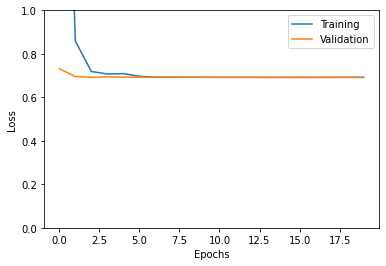

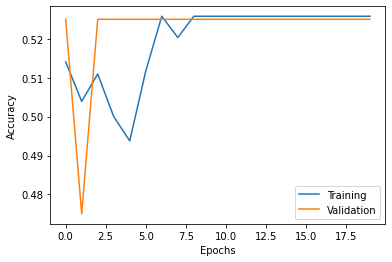

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def nn_hisotry(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylim((0, 1))

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

nn_hisotry(nn)

In [22]:
from keras.models import load_model
model = load_model(r'/content/drive/MyDrive/Personalized Perception/LPIPS Experiment /Models/LIPIS.VGG.D_S.best.hdf5')

In [24]:
import pandas as pd
table={'title':['Accurancy','Val_accurancy'],'value':[max(nn.history['accuracy']),max(nn.history['val_accuracy'])]}
pd.DataFrame(table)

,title,value
0,Accurancy,0.525781
1,Val_accurancy,0.525000


In [27]:
predicted_classes = np.argmax(model.predict(data_test),axis=1)

# see which we predicted correctly and which not

correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")
print(predicted_classes)
print(y_test)


199  classified correctly
201  classified incorrectly
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1
 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0